**#Work in Progress**

Linear regression on New York City Airbnb Open Data. Linear regression is probably not a good model here, but this dataset reminds me of Boston housing data set and I was curious.

Importing essential libraries and examining the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Checking the missing data. As of now, nothing is changed. 

Things to do - Fill the last review data and use the datetime to find how many days it has passed since the last review.

In [2]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Checking the dataframe

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


A few inferences - 
The std. dev for price is very high.

The 25% Q1  for availablity_365 is 0, so many owners don't rent out their properties for even a single day in an year.

If we find exactly how many such cases are there, it's 17533, which is about 35.85% of the dataset.

In [4]:
not_renting_out = np.array(df['availability_365']==0).sum()
print(not_renting_out)
print(not_renting_out/len(df['price'])*100)

17533
35.858472236424994


It's unlikely that owners that don't bother to rent out their homes even once a year are updated with the prices, so we will remove them from our considerations.

Also, many pranksters could rent a place at an extravagant price or (0 price) and keep it at 0 day availability, and that is harmful to our model.

We can see that the row length of our dataframe fell down by 17533. We  could also extrapolate this logic to those with availability less than 5 days, but they might be more aware of price and less likely to be pranksters.

In [5]:
print(df.shape)
df = df[df['availability_365']!=0]
print(df.shape) #New DF shape

(48895, 16)
(31362, 16)


Let's further examine the data frame in detail. There seem to be 3 kinds of categorical data - neighbourhood_group, neighbourhood and room_type.

In [6]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Let's find out how many unique categories lie in those three

In [7]:
print("Room types - ", len(df['room_type'].value_counts()))
print("Neighbourhood groups - ", len(df['neighbourhood_group'].value_counts()))
print("Neighbourhoods - ", len(df['neighbourhood'].value_counts()))

Room types -  3
Neighbourhood groups -  5
Neighbourhoods -  218


There are too many neighbourhood categories. 
We will be proceeding with only room types and neighbourhood groups, because it is likely that neighbourhood inferences are covered in (latitude, longitude) already.

Visualizing the room types and neighbourhoods - 

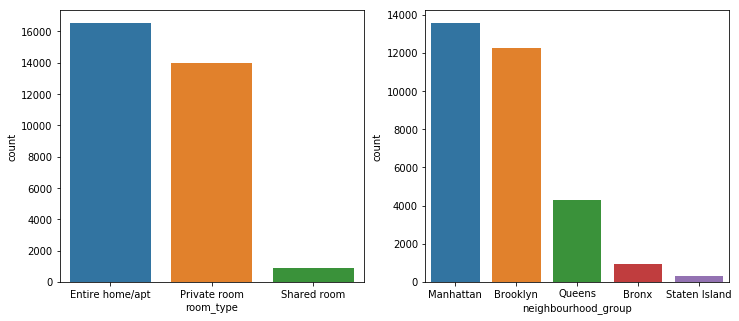

In [8]:
f, axs = plt.subplots(1,2, figsize=(12,5))
#In decscending order by frequency/counts - 
sns.countplot(df['room_type'], order=df['room_type'].value_counts().index,ax=axs[0])
sns.countplot(df['neighbourhood_group'], order=df['neighbourhood_group'].value_counts().index, ax=axs[1])

Convert the room types and neighbourhood groups to numerical categorical data. 

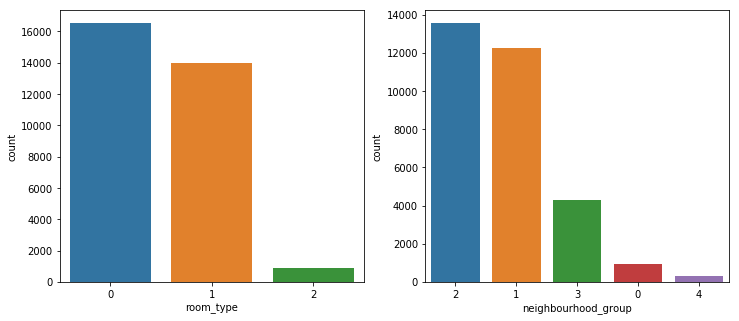

In [9]:
df['room_type'] = df['room_type'].astype('category').cat.codes
df['neighbourhood_group'] = df['neighbourhood_group'].astype('category').cat.codes
f, axs = plt.subplots(1,2, figsize=(12,5))
sns.countplot(df['room_type'], ax=axs[0], order=df['room_type'].value_counts().index)
sns.countplot(df['neighbourhood_group'],order=df['neighbourhood_group'].value_counts().index, ax=axs[1])

In [10]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,1,Kensington,40.64749,-73.97237,1,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,2,Midtown,40.75362,-73.98377,0,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,2,Harlem,40.80902,-73.94190,1,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,1,Clinton Hill,40.68514,-73.95976,0,89,1,270,2019-07-05,4.64,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,2,Murray Hill,40.74767,-73.97500,0,200,3,74,2019-06-22,0.59,1,129


We can see neighbourhood_group and room_type were replaced to be numerical data. 
We will drop features that are unlikely to affect the price - ID, name, host_id, host_name.
We will also drop features that have largely incomplete data - last_review, reviews_per_month or have too many categories - neighbourhood.

In [11]:
df.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'last_review', 'reviews_per_month'], axis=1, inplace=True)

In [12]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,1,40.64749,-73.97237,1,149,1,9,6,365
1,2,40.75362,-73.98377,0,225,1,45,2,355
2,2,40.80902,-73.94190,1,150,3,0,1,365
3,1,40.68514,-73.95976,0,89,1,270,1,194
5,2,40.74767,-73.97500,0,200,3,74,1,129


Now our DataFrame has only numerical data. Let's go ahead and plot the correlation plot and find what affects the price the most - 

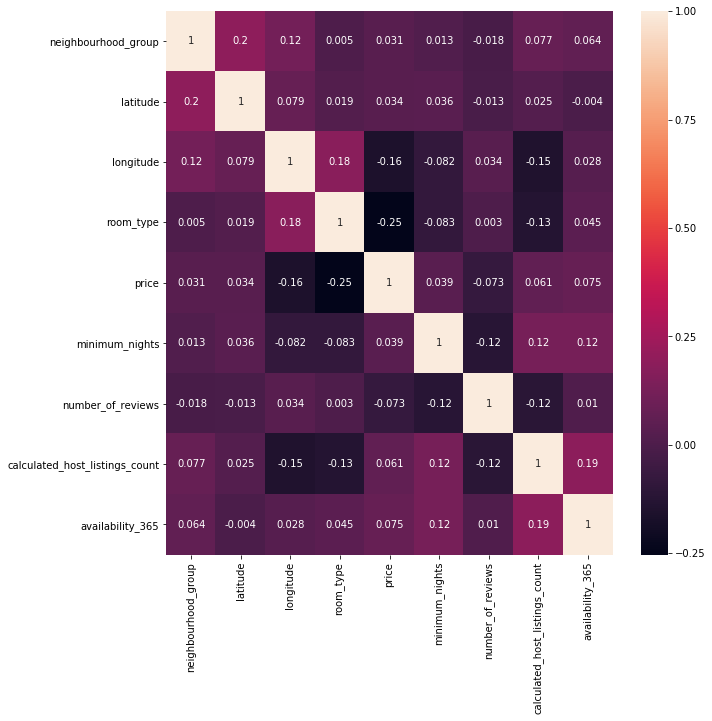

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr().round(3), annot=True)

We take in consideration only the features that seem important and normalize them. Normalizing refers to making the features on the same scale. For example, price can vary from 0 to thousands of dollars, but room_type can only be varied from 0, 1 and 2, so we use normalization to scale all of the features to 0 to 1.

Then we split the overall data into 80% training data and 20% testing data.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Y = df['price']
X = df[['neighbourhood_group', 'longitude', 'room_type', 'availability_365', 'calculated_host_listings_count']]
X = preprocessing.normalize(X)
X = np.hstack((np.ones( (len(df['price']) ,1)), X))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(25089, 6)
(6273, 6)
(25089,)
(6273,)


Import LinearRegression from sklearn and fit our training data. We will be using 2 metrics- RMSE and R2.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

lin_model = LinearRegression().fit(X_train, Y_train)

In [16]:
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2*100))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2*100))

The model performance for training set
--------------------------------------
RMSE is 257.65263847928753
R2 score is 4.45283217412733


The model performance for testing set
--------------------------------------
RMSE is 206.8292794199193
R2 score is 6.471787386125872


Well that's a very disappointing R2 result (this is out of 100).
It means that our model can't explain 95%+ variability of the model.

In [17]:
error_frame = pd.DataFrame({'Actual': np.array(Y_test).flatten(), 'Predicted': y_test_predict.flatten()})
error_frame.head(10)

,Actual,Predicted
0,65,160.851104
1,218,201.691652
2,46,139.281001
3,29,139.653917
4,340,196.458754
5,30,140.564579
6,95,143.824252
7,90,195.100995
8,850,195.471954
9,120,193.870413


Let's try and plot 50 results. 

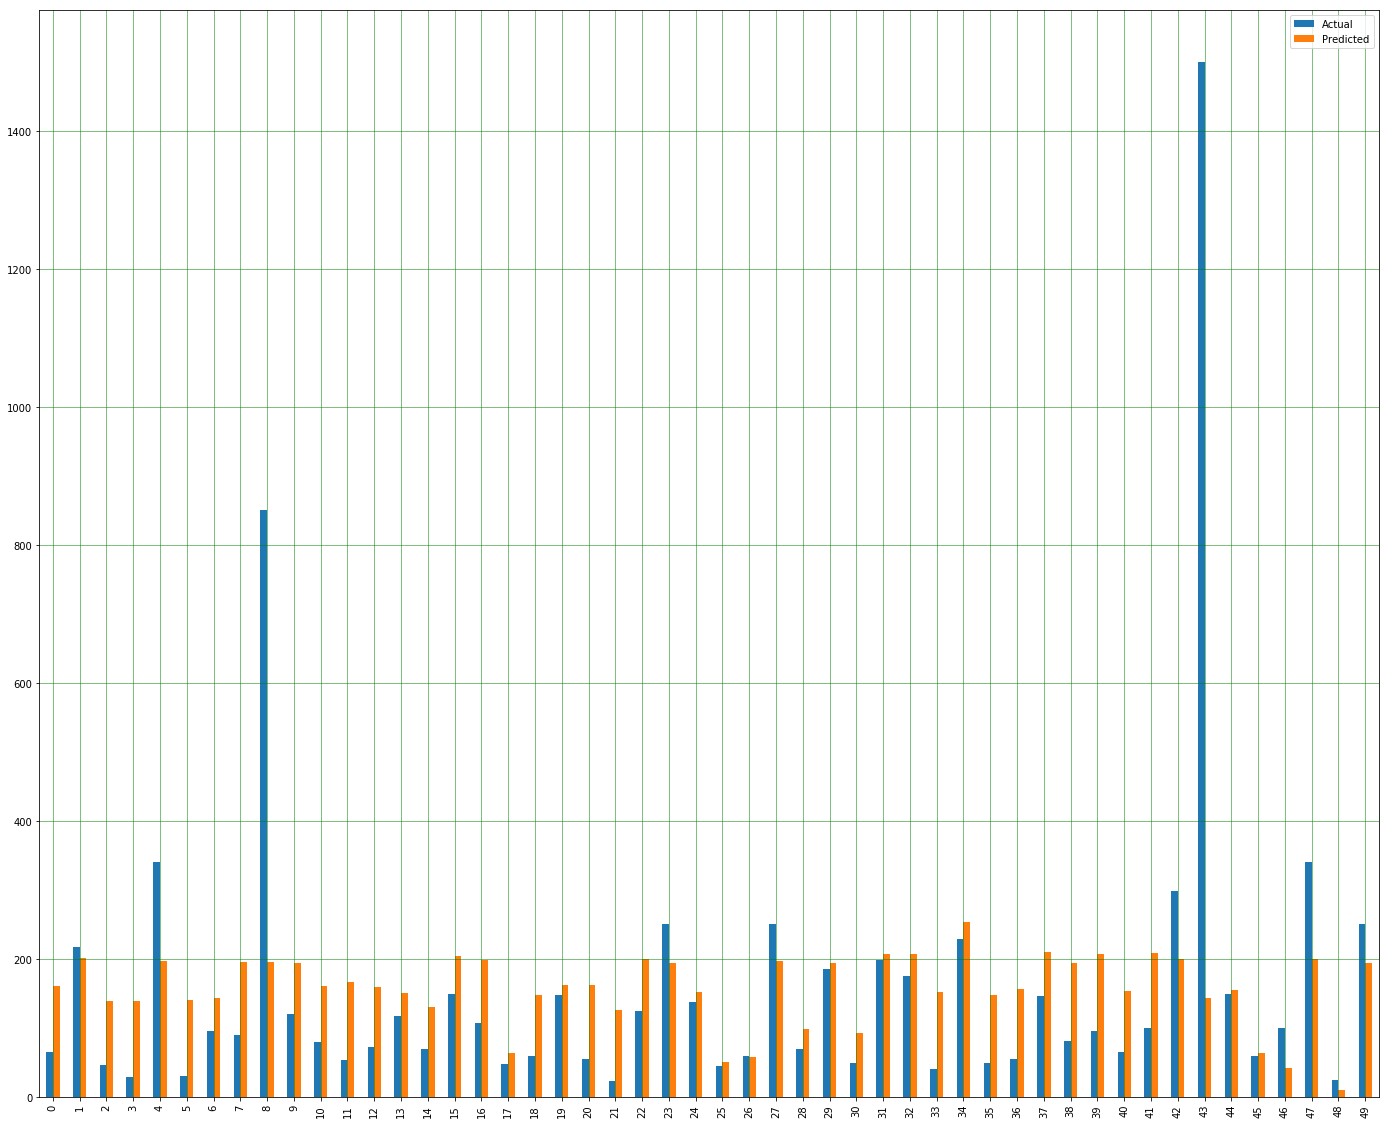

In [18]:
df1 = error_frame[:50]
df1.plot(kind='bar',figsize=(24,20))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

We will use the IQR metric to remove outliers, then fit again. 
From wikipedia - 
>The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In [19]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

Make a new DataFrame with outliers removed.

In [20]:
IQR_df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
IQR_df.shape

(18098, 9)

In [21]:
IQR_df.describe()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,18098.000000,18098.000000,18098.000000,18098.000000,18098.000000,18098.000000,18098.000000,18098.000000,18098.000000
mean,1.591999,40.728034,-73.951773,0.537518,128.956183,2.684827,21.594762,1.640015,147.031550
std,0.713363,0.056723,0.033577,0.549331,75.165450,1.654868,24.210790,1.107168,122.838102
min,0.000000,40.576440,-74.039420,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,40.686820,-73.979540,0.000000,70.000000,1.000000,3.000000,1.000000,35.000000
50%,2.000000,40.720180,-73.951805,1.000000,107.000000,2.000000,12.000000,1.000000,108.000000
75%,2.000000,40.764430,-73.931670,1.000000,175.000000,3.000000,33.000000,2.000000,259.000000
max,3.000000,40.874980,-73.850470,2.000000,367.000000,9.000000,94.000000,6.000000,365.000000


Split the new DataFrame into X_train, Y_train, X_test and Y_test again.

In [22]:
Y = IQR_df['price']
X = IQR_df[['neighbourhood_group', 'longitude', 'room_type', 'availability_365', 'calculated_host_listings_count']]
X = preprocessing.normalize(X)
X = np.hstack((np.ones( (len(IQR_df['price']) ,1)), X))


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(14478, 6)
(3620, 6)
(14478,)
(3620,)


In [23]:
lin_model = LinearRegression().fit(X_train, Y_train)

In [24]:
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2*100))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2*100))

The model performance for training set
--------------------------------------
RMSE is 63.95527156078888
R2 score is 27.994202009888358


The model performance for testing set
--------------------------------------
RMSE is 62.199552191652984
R2 score is 29.975591363307586


Much better, but we also had to ignore a large amount of data to get here.

Still a lot of scope for improvement.

In [25]:
error_frame = pd.DataFrame({'Actual': np.array(Y_test).flatten(), 'Predicted': y_test_predict.flatten()})
error_frame.head(10)

,Actual,Predicted
0,140,180.816961
1,45,112.291282
2,175,162.776791
3,45,-30.569399
4,225,177.596058
5,100,168.685900
6,120,162.701752
7,85,120.878829
8,51,65.720109
9,195,143.966285


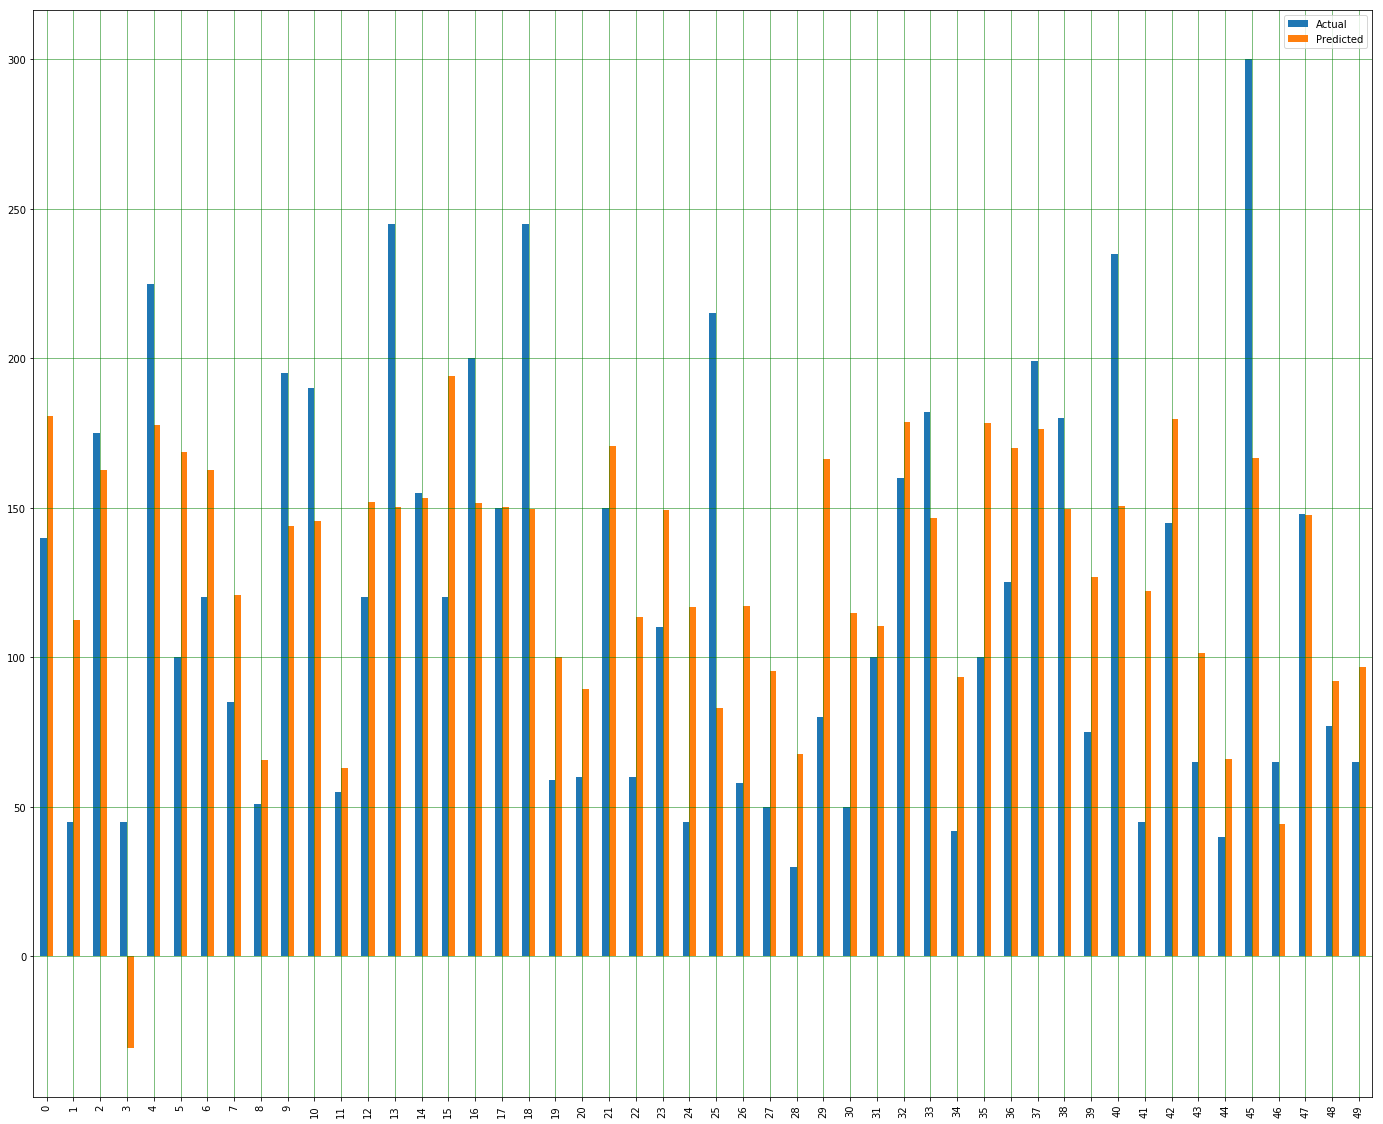

In [26]:
df1 = error_frame[:50]
df1.plot(kind='bar',figsize=(24,20))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Work in progress.